# Quickstart

This notebook showcases the primary features of `jaxdf`. Throughout this tutorial, we will use several libraries from the `jax` ecosystem, including `optax` and `diffrax`. While these libraries are not required to use `jaxdf`, they demonstrate `jaxdf`'s compatibility with the broader `jax` ecosystem.

Let's start by downloading an image to use in this notebook.

In [1]:
import urllib.request
import os

# Download the image if it doesn't already exist
if not os.path.exists("test_img.jpg"):
    url = "https://upload.wikimedia.org/wikipedia/commons/a/a0/Black_and_White_1_-_Augusto_De_Luca_photographer.jpg"
    req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    with urllib.request.urlopen(req) as response:
        with open("test_img.jpg", 'wb') as f:
            f.write(response.read())
    print("Downloaded test_img.jpg")

In [4]:
_ = '''
!pip install opencv-python  # Run if opencv is not installed in your system
!pip install matplotlib     # Run if matplotlib is not installed in your system
'''

In [5]:
from jax import config
config.update("jax_enable_x64", True)

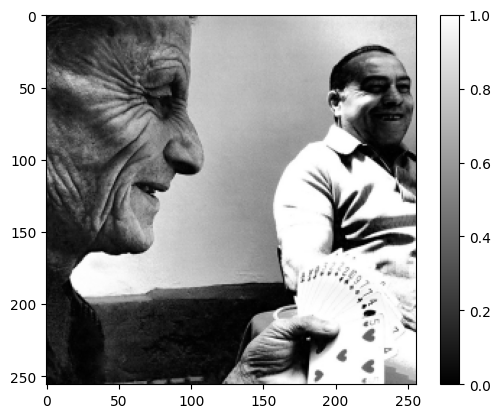

In [6]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread("test_img.jpg")
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()

## Heat Equation

For illustration, we'll simulate the heat equation:

$$
\frac{\partial}{\partial t}u = \nabla^2 u
$$

**NOTE:** We don't enforce specific boundary conditions here, as they are not yet implemented. Currently, boundary conditions are implicitly defined by padding for convolutive operators (Finite Differences) and as periodic boundary conditions (Fourier methods). While this isn't ideal for properly solving the heat equation, it works well when using some form of absorbing layer at the boundary, which is common in acoustics.

A more robust handling of generic boundary conditions would be a valuable addition to the package. **Contributions are welcome!**

<br/>

First, we define the domain where fields are defined. Next, we specify the discretization type that will represent the field. In this case, we use Finite Differences, as represented by the `FiniteDifferences` discretization.

In [7]:
from jaxdf.geometry import Domain

# Setting the domain.
domain = Domain(N=img.shape, dx=(1., 1.))

In [8]:
from jax import numpy as jnp
import numpy as np
from jaxdf.discretization import FiniteDifferences, OnGrid

# We define the grid values from the image, making sure they are a jax.numpy array of floats
grid_values = jnp.asarray(img, dtype=np.float32)         

# Then the field is defined by the combination of grid values and domain
u = FiniteDifferences.from_grid(grid_values, domain)

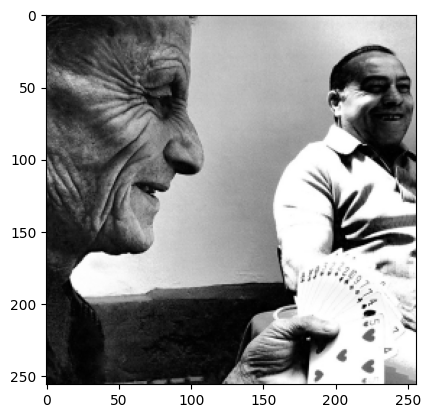

In [9]:
from matplotlib import pyplot as plt

# We can get the field on the domain grid using the .on_grid method
plt.imshow(u.on_grid, cmap="gray")

Now, let's define the right-hand side of the heat equation. Since the only operator required is the Laplacian, we can use `operators.laplacian` to compute it.

In [10]:
from jaxdf.operators.differential import laplacian
from jax import jit

# Make RHS operator
@jit   # We can jit the entire function, `Field`s from jaxdf are compatible with jax
def heat_rhs(u):
    return laplacian(u)

# Apply the rhs of the operator
z = heat_rhs(u)

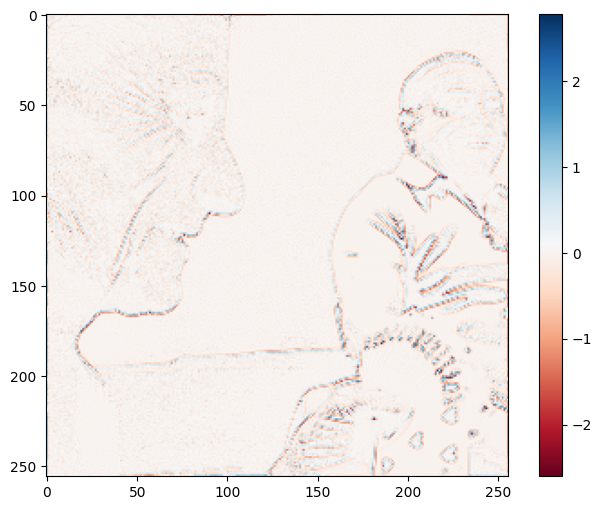

In [11]:
# Look at the output of the laplacian
plt.figure(figsize=(8,6))
plt.imshow(z.on_grid, cmap='RdBu'); plt.colorbar()

### Integration using `diffrax`

In this section, we will integrate the heat equation using the `diffrax` library, which provides a suite of differential equation solvers.

1. **Setting up the PDE**: First, we define the PDE field, which is represented by the Laplacian of \( u \).

2. **Configuring the Solver and Time Steps**: 
   - We choose `Tsit5` as our solver.
   - We set the initial time `t0` to 0 and the final time `t_final` to 20.
   - The time step `dt` is set to 0.1.
   - Using the `SaveAt` feature, we save results at evenly spaced time points.

3. **Solving the PDE**: Using `dfx.diffeqsolve`, we pass in our term, the chosen solver, time configurations, and the initial field `u` to obtain the solution.

Let's dive into the code:

In [12]:
#!pip install diffrax # Install this for numerical integration in jax

In [13]:
# Integrate with diffrax
import diffrax as dfx

def pde_field(t, u, args):
  return laplacian(u)

term = dfx.ODETerm(pde_field)
t0 = 0
t_final = 20
dt = 0.1
saveat = dfx.SaveAt(ts=jnp.linspace(t0, t_final, 10))
solver = dfx.Tsit5()

sol = dfx.diffeqsolve(term, solver, t0, t_final, dt, u, saveat=saveat)

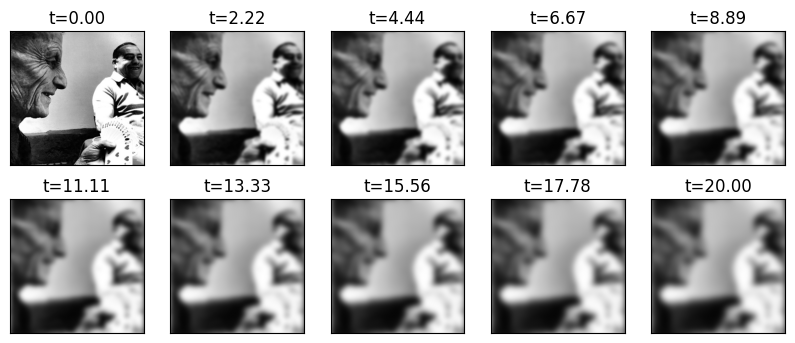

In [14]:
snapshots = sol.ys

# Plot the solutions on a grid
fig, ax = plt.subplots(2, 5, figsize=(10,4))
# Flatten the axes
ax = ax.flatten()
for i in range(10):
  ax[i].imshow(snapshots[i].on_grid, vmin=0, vmax=1.0, cmap="gray")
  ax[i].set_title(f"t={sol.ts[i]:.2f}")
  ax[i].set_xticks([])
  ax[i].set_yticks([])

### Anisotropic Diffusion Example

Anisotropic diffusion is a more sophisticated form of heat diffusion where the diffusion rate varies in both direction and magnitude, often depending on the underlying structure of the data. This is particularly useful in applications like image processing, where it helps preserve edges while diffusing noise.

Let's see how we can use `jaxdf` to define and solve an anisotropic diffusion problem.

The anisotropic diffusion equation can be represented as:

$$
\frac{\partial u}{\partial t} = \nabla \cdot (c(u) \nabla u)
$$

Where:
- $u$ is the field of interest.
- $c(u)$ is the diffusion conductivity that varies depending on the gradient magnitude of \( u \).

To translate this to code:

- **Divergence Operator**: We define the divergence of a vector field, `divergence(u, stagger)`, which computes the rate at which density exits at each point—essential for understanding how diffusion spreads. Note that we use staggered gradients, which are a feature of `OnGrid` fields.

- **Diffusion Conductivity**: `conductivity_kernel(u)` computes the conductivity based on the magnitude of the gradient of $u$. The kernel ensures that areas with high gradients (like edges) have lower conductivity, thereby preserving features.

- **Gradient Magnitude**: `norm(u)` computes the magnitude of the gradient, which determines the diffusion rate.

- **Complete Anisotropic Diffusion**: `anisotropic_diffusion(t, u, args)` combines the above functions to compute the divergence of the conductivity-weighted gradient of $u$, yielding the right-hand side of our PDE.

In [15]:
from jaxdf.operators.differential import laplacian, gradient, diag_jacobian
from jaxdf.operators.functions import compose, sum_over_dims

# What if we want to use anisotropic diffusion?
def divergence(u, stagger): # Defining the divergence operator
  return sum_over_dims(diag_jacobian(u, stagger=stagger))

def conductivity_kernel(u): # Defining the diffusion kernel
  kernel = lambda x: 1/(1 + (x/0.03)**2)
  return compose(u)(kernel)

def norm(u):
  z = sum_over_dims(u**2)
  return compose(z)(jnp.sqrt)

@jit
def anisotropic_diffusion(t, u, args):
  grad_u = gradient(u, stagger=[0.5])
  mod_gradient = norm(grad_u)
  c = conductivity_kernel(mod_gradient)
  return divergence(c * grad_u, stagger=[-0.5])

# Plot the effect of the kernel
z = anisotropic_diffusion(0, u, None)
plt.imshow(z.on_grid, cmap="RdBu")
plt.colorbar()
plt.savefig("anisotropic_kernel.png")
plt.close()

term = dfx.ODETerm(anisotropic_diffusion)
sol = dfx.diffeqsolve(term, solver, t0, t_final, dt, u, saveat=saveat)

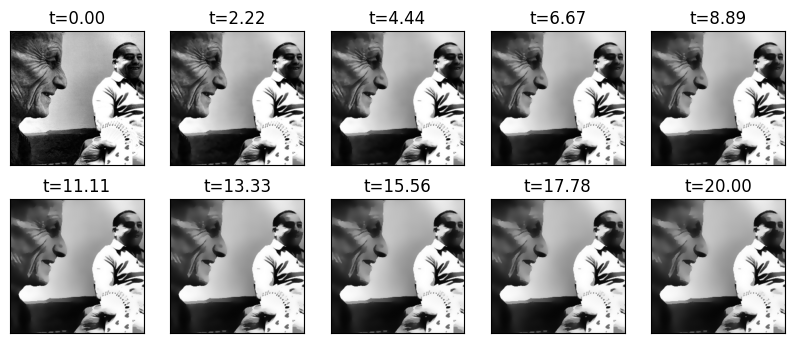

In [16]:
snapshots = sol.ys

# Plot the solutions on a grid
fig, ax = plt.subplots(2, 5, figsize=(10,4))
# Flatten the axes
ax = ax.flatten()
for i in range(10):
  ax[i].imshow(snapshots[i].on_grid, vmin=0, vmax=1.0, cmap="gray")
  ax[i].set_title(f"t={sol.ts[i]:.2f}")
  ax[i].set_xticks([])
  ax[i].set_yticks([])

By constructing the anisotropic diffusion operator using `jaxdf`, we've highlighted several key features of the library:

- **Composition**: The ability to define complex differential operators, such as divergence, gradient, and custom conductivity kernels, by composing simpler operators.
- **Performance**: Using `@jit` to just-in-time compile functions, ensuring optimal performance during execution.

## Customizing the Discretization

Exploring different discretizations is a powerful feature in `jaxdf`. For instance, transitioning from `FiniteDifferences` to `FourierSeries` discretization is seamless:

1. **Define a New Field**: Initialize your field using the desired `FourierSeries` discretization.
2. **Invoke the Operator**: Simply call the previously defined operator on the newly discretized field.

This flexibility allows researchers and developers to effortlessly experiment with various discretizations, often without modifying their primary operators.

In [17]:
from jaxdf.discretization import FourierSeries

u_f = FourierSeries.from_grid(u.on_grid, domain)

# We can reuse the previous code!
sol = dfx.diffeqsolve(term, solver, t0, t_final, dt, u_f, saveat=saveat)
snapshots_fourier = sol.ys

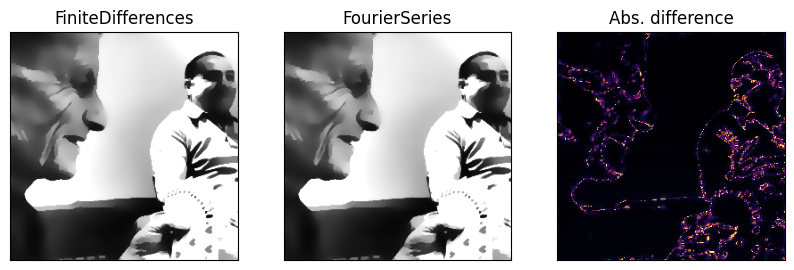

In [18]:
# Plot the solutions on a grid
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax = ax.flatten()
ax[0].imshow(snapshots[-1].on_grid, vmin=0, vmax=0.8, cmap="gray")
ax[0].set_title(f"FiniteDifferences")
ax[1].imshow(snapshots_fourier[-1].on_grid, vmin=0, vmax=0.8, cmap="gray")
ax[1].set_title(f"FourierSeries")
difference = np.abs(snapshots_fourier[-1].on_grid - snapshots[-1].on_grid)
ax[2].imshow(difference, vmin=0, vmax=0.1, cmap="inferno")
ax[2].set_title(f"Abs. difference")

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

## Automatic Differentiation with `jaxdf`

One of the key strengths of the `jaxdf` framework is its seamless integration with `jax`'s automatic differentiation capabilities. By leveraging `jax`'s native transformations, you can efficiently compute gradients with respect to the arguments of operators.

Loss: 1.5509735579348392


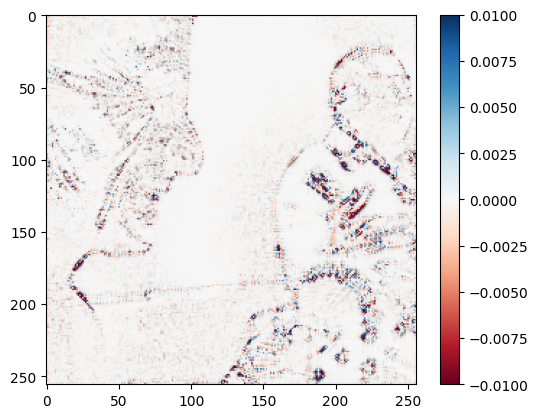

In [19]:
from jax import value_and_grad

@value_and_grad
def loss_fn(u: FourierSeries):
    y = compose(2*jnp.pi*u)(jnp.sin)
    z = laplacian(y)
    return jnp.mean(z.on_grid**2)

lossval, z = loss_fn(u_f)

# The gradient is once again a Field
plt.imshow(z.on_grid, cmap="RdBu" , vmin=-0.01, vmax=0.01)
plt.colorbar()
print(f"Loss: {lossval}")

## Handling Operator Parameters

Operators in computational methods often have associated parameters that are critical to their computation. In `jaxdf`, these parameters can be discretization-dependent, adapting based on the specific method in use.

For instance, the `laplacian` operator:
- For `FiniteDifferences`, it's implemented using a stencil.
- For `FourierSeries`, it relies on transformations of the spatial frequency axis (k-axis).

The `.default_params` method provides insight into these parameters. When invoked with the same arguments as the operator, it returns the default parameters being used.

Text(0.5, 1.0, 'Laplacian stencil for FiniteDifferences fields')

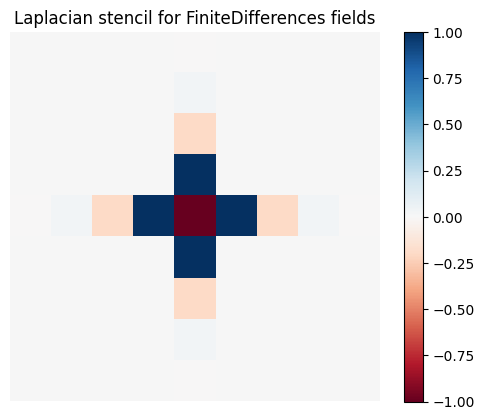

In [20]:
# Get the operator parameters for a FiniteDifferences field
# (remember that type(u) = FiniteDifferences)
fd_stencil = laplacian.default_params(u)     

plt.imshow(fd_stencil, vmin=-1, vmax=1, cmap="RdBu")
plt.colorbar()
plt.axis('off')
plt.title("Laplacian stencil for FiniteDifferences fields")

In [21]:
# Get the operator parameters for a FourierSeries field
# (remember that type(u) = FourierSeries)
f_params = laplacian.default_params(u_f)
f_params.keys()

dict_keys(['k_vec'])

By design, these parameters are statically compiled into the XLA function. However, `jaxdf` offers flexibility for scenarios such as:
- Parameters have been manually adjusted.
- Parameters are large, making static compilation inefficient.
- Different operators share the same parameters, as seen in Fourier methods. In such cases, you might want to use a consistent variable across all operators.

To accommodate these scenarios, every `operator` in `jaxdf` has a `params` keyword argument. This reserved keyword allows you to override default parameters, giving you precise control over the computation.

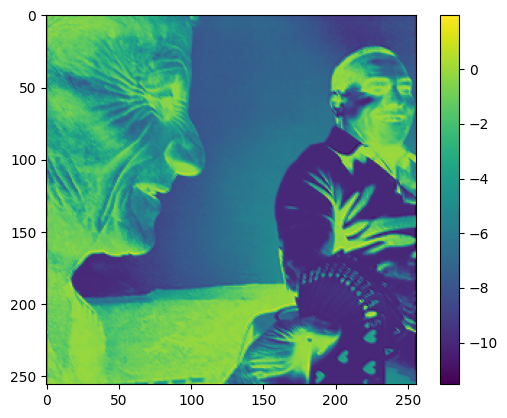

In [22]:
# Get the default parameters
stencil = laplacian.default_params(u)

# Change the middle element
stencil[5,5] = -10.0

# Call the laplacian with the new parameters
z = laplacian(u, params=stencil)

# Check the result
plt.imshow(z.on_grid)
plt.colorbar()

`jaxdf` doesn't just provide access to parameters—you can also apply functional transformations directly to them!

To illustrate this, let's optimize the stencil of the `laplacian` operator for a `FiniteDifferences` field to align its output more closely with the `FourierSeries` version.

In [23]:
stencil = laplacian.default_params(u)

@value_and_grad
def loss_fn(stencil, u: FiniteDifferences, v: FourierSeries):
    z_fd = laplacian(u, params=stencil)  # Note the explicit parameters being passed
    z_fs = laplacian(v)

    mse = jnp.sum(((z_fd - z_fs)**2).on_grid)
    return mse

lossval, stencil_grad = loss_fn(stencil, u, u_f)

In [25]:
# !pip install optax    # Install optax for optimization in jax

In [26]:
import optax

optimizer = optax.adam(0.02)
opt_state = optimizer.init(stencil)
new_stencil = stencil

@jit
def step(stencil, opt_state, u, v):
    lossval, stencil_grad = loss_fn(stencil, u, u_f)
    
    updates, opt_state = optimizer.update(stencil_grad, opt_state)
    stencil = optax.apply_updates(stencil, updates)
    return lossval, stencil, opt_state

for i in range(4001):
    lossval, new_stencil, opt_state = step(new_stencil, opt_state, u, u_f) 
    if i % 500 == 0:
        print(f"Step: {i} - Loss {lossval}")

Step: 0 - Loss 142.65943447348533
Step: 500 - Loss 74.48530297466988
Step: 1000 - Loss 39.88116515765783
Step: 1500 - Loss 20.866284407035973
Step: 2000 - Loss 13.67166134209312
Step: 2500 - Loss 10.21218452608835
Step: 3000 - Loss 8.494168698027876
Step: 3500 - Loss 7.603157098267076
Step: 4000 - Loss 7.124689183017861


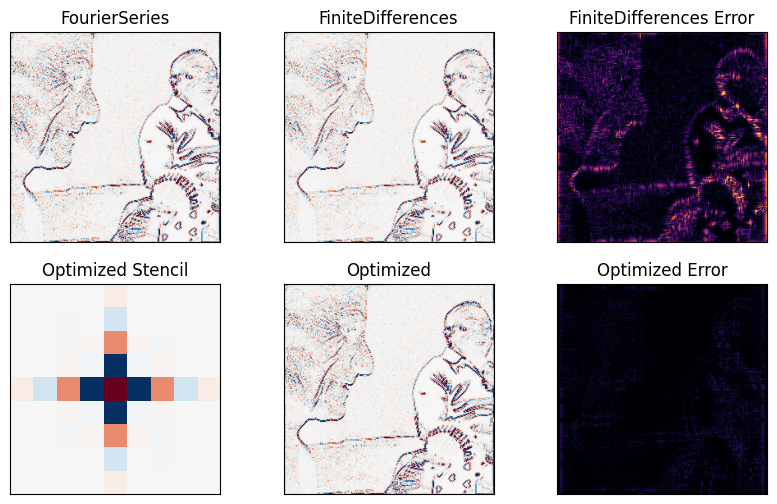

In [27]:
# Check the performances
z_FD  = laplacian(u)
z_FS  = laplacian(u_f)
z_opt = laplacian(u, params = new_stencil)

fd_diff = jnp.abs((z_FD - z_FS).on_grid)
opt_diff = jnp.abs((z_opt - z_FS).on_grid)

fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax = ax.flatten()
ax[0].imshow(z_FS.on_grid, vmin=-1, vmax=1, cmap="RdBu")
ax[0].set_title(f"FourierSeries")
ax[1].imshow(z_FD.on_grid, vmin=-1, vmax=1, cmap="RdBu")
ax[1].set_title(f"FiniteDifferences")
ax[2].imshow(fd_diff, vmin=0, vmax=0.3, cmap="inferno")
ax[2].set_title(f"FiniteDifferences Error")
ax[3].imshow(new_stencil, vmin=-1, vmax=1, cmap="RdBu")
ax[3].set_title(f"Optimized Stencil")
ax[4].imshow(z_opt.on_grid, vmin=-1, vmax=1, cmap="RdBu")
ax[4].set_title(f"Optimized")
ax[5].imshow(opt_diff, vmin=0, vmax=0.3, cmap="inferno")
ax[5].set_title(f"Optimized Error")

for i in range(6):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

## More Complex Operators

We can construct more complex operators than the heat equation using composition. Beyond the core functionality of operators, `jaxdf` provides direct access to the numerical parameters of fields. This feature is invaluable for scenarios requiring fine-tuned control or experimentation with parameters.

In [28]:
from jaxdf.operators.functions import compose
from jaxdf import Field
from jax.nn import relu
from jax import random, lax

seed = random.PRNGKey(42)
cnn_kernel = random.normal(seed, (1,1,3,3))

def silly_cnn(x: jnp.ndarray, kernel: jnp.ndarray):
    x = jnp.moveaxis(x, -1, 0)
    x = jnp.expand_dims(x,0)
    out_conv = lax.conv(x, cnn_kernel, (1,1), padding='same')
    out_conv = relu(out_conv)[0]
    out = jnp.moveaxis(out_conv, 0, -1)
    return out

@jit
def f(u: Field):
    L = laplacian(u)
    
    field_on_grid = L.on_grid # Represent the field as a standard jnp array
    new_grid_values = silly_cnn(field_on_grid, cnn_kernel)  # Manipulate its values with a neural network
    p = FiniteDifferences.from_grid(new_grid_values, u.domain) # Generate a new FiniteDifferences field

    # Apply jaxdf operators again
    p = compose(p)(jnp.sin)
    return 0.01*p

In [29]:
z = f(u)
print(z)

FiniteDifferences(
  params=f64[256,256,1], domain=Domain(N=(256, 256), dx=(1.0, 1.0))
)
